In [2]:
import os
os.chdir("/content/drive/MyDrive/ug-project/src")
!pwd
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/ug-project/src
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import torchvision.transforms.v2 as v2
from datasets import FaceScrubDataset, FACESCRUB_MEAN, FACESCRUB_STD
from torch.utils.data import DataLoader
from model import ResNet18Sup

### Set hyperparameters

In [4]:
learning_rate = 0.01
epochs = 50
batch_size = 256

### Define transforms

In [5]:
prob = 0.2
color_transforms = [v2.RandomApply([v2.ColorJitter(brightness=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(hue=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(saturation=0.2)], p=prob),
                    v2.RandomApply([v2.ColorJitter(contrast=0.2)], p=prob),
                    v2.RandomEqualize(p=prob),
                    v2.RandomPosterize(bits=4, p=prob),
                    v2.RandomAutocontrast(p=prob)
                    ]
transform = v2.Compose([v2.ToPILImage(),
                        v2.Resize((256, 256)),
                        v2.RandomResizedCrop(size=224, scale=(0.5, 1.0), interpolation=v2.InterpolationMode.BICUBIC),
                        v2.RandomOrder(color_transforms),
                        v2.RandomHorizontalFlip(),
                        v2.ToTensor(),
                        v2.Normalize(mean=FACESCRUB_MEAN, std=FACESCRUB_STD)
                        ])
transform_test = v2.Compose([
    v2.ToPILImage(),
    v2.Resize(224),
    v2.ToTensor(),
    v2.Normalize(mean=FACESCRUB_MEAN, std=FACESCRUB_STD)
])

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### Load FaceScrub dataset

In [6]:
train_dataset = FaceScrubDataset(train=True, hypertune=True, transform=transform)
print(f"Dev set size: {len(train_dataset)}")

test_dataset = FaceScrubDataset(train=False, hypertune=False, transform=transform_test)
print(f"Test set size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=True, persistent_workers=True)

Dev set size: 23488
Test set size: 2936


### Create ResNet18 model

In [7]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clear_model = ResNet18Sup(num_classes=297).to(device)
blur_model = ResNet18Sup(num_classes=297).to(device)

criterion = nn.CrossEntropyLoss()
clear_optimizer = torch.optim.Adam(clear_model.parameters(), lr=learning_rate, weight_decay=1e-5)
blur_optimizer = torch.optim.Adam(blur_model.parameters(), lr=learning_rate, weight_decay=1e-5)
steps = len(train_loader)
clear_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=clear_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
clear_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=clear_optimizer, T_max=(epochs - 2) * steps)
clear_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=clear_optimizer,
                                                            schedulers=[clear_warmup_scheduler, clear_decay_scheduler],
                                                            milestones=[2*steps+1])
blur_warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=blur_optimizer, start_factor=0.01, end_factor=1.0,
                                                      total_iters=2*steps)
blur_decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=blur_optimizer, T_max=(epochs - 2) * steps)
blur_combined_scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer=blur_optimizer,
                                                            schedulers=[blur_warmup_scheduler, blur_decay_scheduler],
                                                            milestones=[2*steps+1])

### Evaluate model before training

In [8]:
!pip install kornia

In [9]:
from utils import add_blur_with

# Initialize metrics for ploting
clear_train_correct, clear_val_correct = [], []
blur_train_correct, blur_val_correct = [], []

clear_model.eval()
blur_model.eval()
blur_train_corr, clear_train_corr, total_train = 0, 0, 0

with torch.no_grad():
    for _, images, labels in train_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        clear_y_pred = clear_model(images)
        blur_y_pred = blur_model(images)
        clear_predicted = torch.max(clear_y_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_pred.data, 1)[1]
        clear_train_corr += (clear_predicted == labels).sum().item()
        blur_train_corr += (blur_predicted == labels).sum().item()
        total_train += labels.size(0)

clear_train_accuracy = (clear_train_corr / total_train) * 100
blur_train_accuracy = (blur_train_corr / total_train) * 100

clear_val_corr, blur_val_corr, total_val = 0, 0, 0

with torch.no_grad():
    for _, images, labels in test_loader:
        images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        images, labels = images.to(device), labels.to(device)

        clear_y_val_pred = clear_model(images)
        blur_y_val_pred = blur_model(images)
        clear_predicted = torch.max(clear_y_val_pred.data, 1)[1]
        blur_predicted = torch.max(blur_y_val_pred.data, 1)[1]
        clear_val_corr += (clear_predicted == labels).sum().item()
        blur_val_corr += (blur_predicted == labels).sum().item()
        total_val += labels.size(0)


clear_val_accuracy = (clear_val_corr / total_val) * 100
blur_val_accuracy = (blur_val_corr / total_val) * 100


# Save results for plotting
clear_train_correct.append(clear_train_accuracy)
clear_val_correct.append(clear_val_accuracy)
blur_train_correct.append(blur_train_accuracy)
blur_val_correct.append(blur_val_accuracy)

print(f"Epoch {0}/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear val acc: {clear_val_accuracy:.2f}%, Blur train acc: {blur_train_accuracy:.4f}%, Blur val acc: {blur_val_accuracy:.2f}%")

Epoch 0/50, Clear train acc: 0.3348%, Clear val acc: 0.36%, Blur train acc: 0.3219%, Blur val acc: 0.28%


### Training loop

In [10]:
for epoch in range(0, epochs):

    ###################### Train model #########################
    clear_model.train()
    blur_model.train()
    for _, images, labels in train_loader:

        # Apply blur sigma depending on training stage
        if epoch < 10:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
        elif epoch >= 10 and epoch < 20:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 1, 0])
        elif epoch >= 20 and epoch < 30:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 1, 0, 0])
        elif epoch >= 30 and epoch < 40:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 1, 0, 0, 0])
        elif epoch >= 40:
            blurred_images = add_blur_with(images, [0, 1, 2, 4, 8], [1, 0, 0, 0, 0])

        blurred_images, labels = blurred_images.to(device), labels.to(device)
        images = images.to(device)
        clear_optimizer.zero_grad()
        blur_optimizer.zero_grad()
        clear_logits = clear_model(images)
        blur_logits = blur_model(blurred_images)
        clear_loss = criterion(clear_logits, labels)
        clear_loss.backward()
        blur_loss = criterion(blur_logits, labels)
        blur_loss.backward()
        clear_optimizer.step()
        blur_optimizer.step()
        clear_combined_scheduler.step()
        blur_combined_scheduler.step()

    # Evaluate on training set
    clear_model.eval()
    blur_model.eval()
    clear_train_corr, blur_train_corr, total_train = 0, 0, 0

    with torch.no_grad():
        for _, images, labels in train_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)
            images = images.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(images)
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_train_corr += (clear_predicted == labels).sum().item()
            blur_train_corr += (blur_predicted == labels).sum().item()
            total_train += labels.size(0)

    clear_train_accuracy = (clear_train_corr / total_train) * 100
    blur_train_accuracy = (blur_train_corr / total_train) * 100


    ###################### Evaluate model ######################
    clear_val_corr, blur_val_corr, total_val = 0, 0, 0

    with torch.no_grad():
        for _, images, labels in test_loader:
            images = add_blur_with(images, [0, 1, 2, 4, 8], [0, 0, 0, 0, 1])
            images, labels = images.to(device), labels.to(device)

            clear_y_pred = clear_model(images)
            blur_y_pred = blur_model(images)
            clear_predicted = torch.max(clear_y_pred.data, 1)[1]
            blur_predicted = torch.max(blur_y_pred.data, 1)[1]
            clear_val_corr += (clear_predicted == labels).sum().item()
            blur_val_corr += (blur_predicted == labels).sum().item()
            total_val += labels.size(0)

    clear_val_accuracy = (clear_val_corr / total_val) * 100
    blur_val_accuracy = (blur_val_corr / total_val) * 100

    clear_train_correct.append(clear_train_accuracy)
    clear_val_correct.append(clear_val_accuracy)
    blur_train_correct.append(blur_train_accuracy)
    blur_val_correct.append(blur_val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Clear train acc: {clear_train_accuracy:.4f}%, Clear val acc: {clear_val_accuracy:.2f}%, Blur train acc: {blur_train_accuracy:.4f}%, Blur val acc: {blur_val_accuracy:.2f}%")

Epoch 1/50, Clear train acc: 1.0689%, Clear val acc: 1.17%, Blur train acc: 0.6310%, Blur val acc: 0.75%
Epoch 2/50, Clear train acc: 1.0517%, Clear val acc: 1.38%, Blur train acc: 1.0345%, Blur val acc: 0.85%
Epoch 3/50, Clear train acc: 0.7212%, Clear val acc: 0.75%, Blur train acc: 4.4042%, Blur val acc: 4.79%
Epoch 4/50, Clear train acc: 1.8802%, Clear val acc: 1.35%, Blur train acc: 11.3711%, Blur val acc: 11.47%
Epoch 5/50, Clear train acc: 2.0089%, Clear val acc: 1.95%, Blur train acc: 19.1235%, Blur val acc: 18.36%
Epoch 6/50, Clear train acc: 2.2794%, Clear val acc: 2.20%, Blur train acc: 24.3003%, Blur val acc: 21.73%
Epoch 7/50, Clear train acc: 2.1463%, Clear val acc: 1.74%, Blur train acc: 41.0972%, Blur val acc: 40.13%
Epoch 8/50, Clear train acc: 3.5328%, Clear val acc: 3.09%, Blur train acc: 47.8880%, Blur val acc: 47.48%
Epoch 9/50, Clear train acc: 3.8934%, Clear val acc: 3.20%, Blur train acc: 48.1757%, Blur val acc: 46.38%
Epoch 10/50, Clear train acc: 3.4427%, Clea

### Plot clear model accuracy

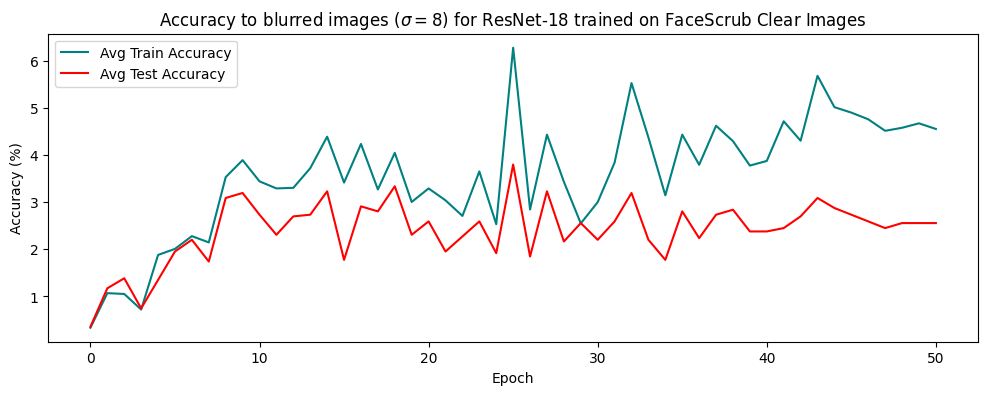

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(clear_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(clear_val_correct, color='red', label='Avg Test Accuracy')
plt.title(r'Accuracy to blurred images ($\sigma=8$) for ResNet-18 trained on FaceScrub Clear Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Plot blur model accuracy

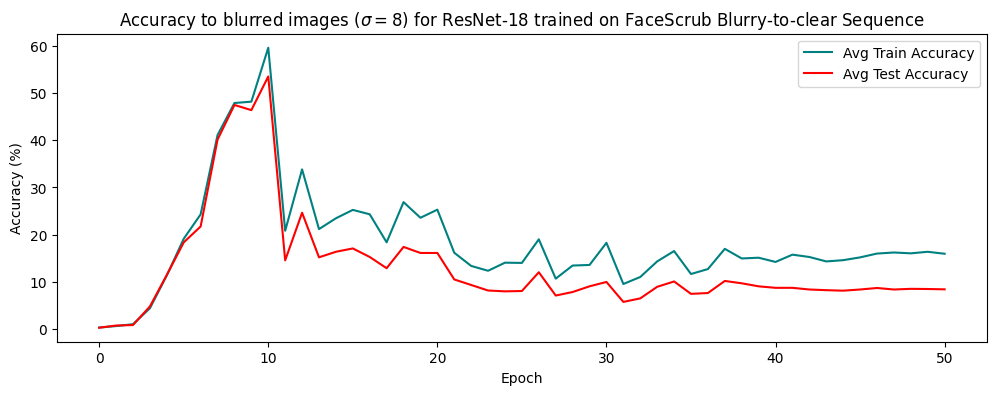

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(blur_train_correct, color='teal', label='Avg Train Accuracy')
plt.plot(blur_val_correct, color='red', label='Avg Test Accuracy')
plt.title(r'Accuracy to blurred images ($\sigma=8$) for ResNet-18 trained on FaceScrub Blurry-to-clear Sequence')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()